In [1]:
%pip -q install timesfm jax seaborn
import timesfm
import pandas as pd
import numpy as np
#Let's Visualise the Datas
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Note: you may need to restart the kernel to use updated packages.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:17:24) [GCC 13.3.0].


In [ ]:
file_path = "./de_hourly_energy_load.csv" # Use the avg_hourly_processed_data_with_features found in the Data file
df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)
# To take a subset of the data that fits the data points used in the training stage
data = df[:700] 
data['time']=pd.to_datetime(data['time'])
data.head()

,time,load,residual,pumped,date,Hour,month,weekday,hour
0,2018-11-01 00:00:00,48879.50,34530.00,3295.75,01/11/2018,00:00:00,11,3,0
1,2018-11-01 01:00:00,47312.50,33605.50,3848.00,01/11/2018,01:00:00,11,3,1
2,2018-11-01 02:00:00,46093.75,32232.00,4452.25,01/11/2018,02:00:00,11,3,2
3,2018-11-01 03:00:00,46710.50,33261.75,4855.75,01/11/2018,03:00:00,11,3,3
4,2018-11-01 04:00:00,47624.25,33987.75,3854.50,01/11/2018,04:00:00,11,3,4


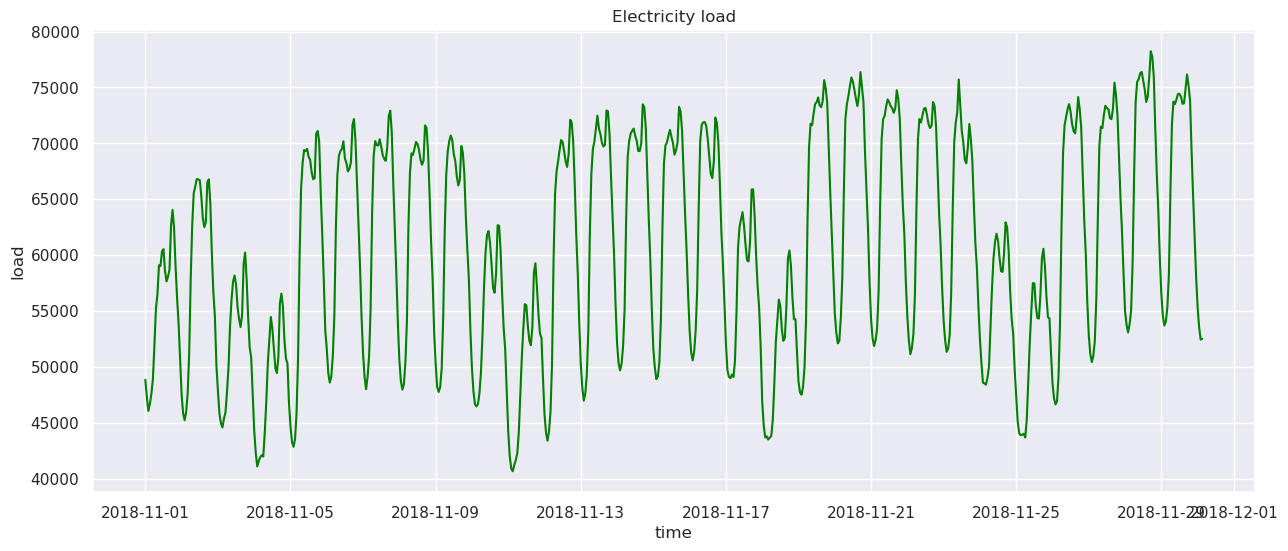

In [ ]:

warnings.filterwarnings('ignore') # To ignore the warnings 
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x="time", y='load', data=data, color='green')
plt.title('Electricity load')
plt.xlabel('time')
plt.ylabel('load')
plt.show()

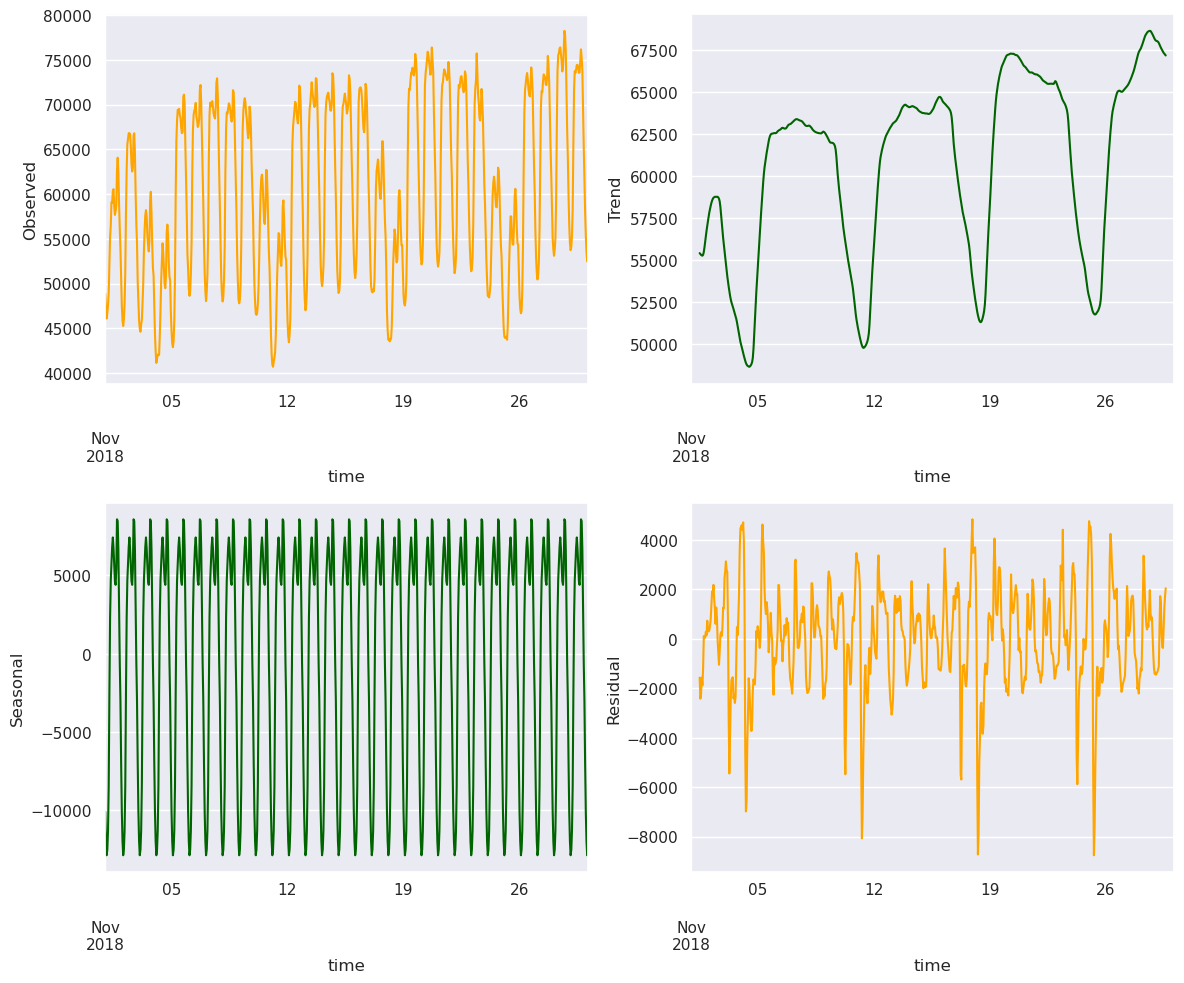

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# We set index to DATE and decompose the data
data.set_index("time", inplace=True)
result = seasonal_decompose(data['load'])
# To create a 2x2 grid for the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
result.observed.plot(ax=ax1, color='orange')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, color='darkgreen')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, color='darkgreen')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, color='orange')
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()
# To adjust layout and show the plots
plt.tight_layout()
plt.savefig('hourly load decomposed with TimesFM.png')
plt.show()
# Then reset the index after plotting
data.reset_index(inplace=True)

In [ ]:
df = pd.DataFrame({'unique_id':[1]*len(data),'ds': data["time"], "y":data['load']})
# To ensure the correct column names
df = pd.DataFrame({'unique_id': [1] * len(data), 'ds': data["time"], 'load': data['load']})

# we use x to split the data
x=(1-128/len(data['load']))
split_idx = int(len(df) * x)
# splitting the dataframe into train and test sets
train_df = df[:split_idx]
test_df = df[split_idx:]
print(train_df.shape, test_df.shape)
print(train_df.head())

(572, 3) (128, 3)
   unique_id                  ds      load
0          1 2018-11-01 00:00:00  48879.50
1          1 2018-11-01 01:00:00  47312.50
2          1 2018-11-01 02:00:00  46093.75
3          1 2018-11-01 03:00:00  46710.50
4          1 2018-11-01 04:00:00  47624.25


In [ ]:
# To load TimesFM pretrained checkpoints with hyperparameters
tfm = timesfm.TimesFm(
  hparams = timesfm.TimesFmHparams(
    context_len=512, # max 512, can be shorter
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # ‘gpu’ when using GPU backend for fine-tuning
  ),
  checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
  )
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# To generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=train_df,           # Input DataFrame containing the time-series data for training
    freq="H",                  # Frequency of the time-series data (e.g., 'M' for monthly, 'D' for daily)
    value_name="load",        # Name of the column containing the values to be forecasted
    num_jobs=-1,               # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [9]:
timesfm_forecast.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2018-11-24 20:00:00,58256.843750,56579.070312,57252.460938,57614.878906,57928.527344,58256.843750,58544.117188,58944.503906,59376.562500,60122.464844
1,1,2018-11-24 21:00:00,55527.789062,53902.757812,54496.863281,55068.390625,55255.558594,55527.789062,55995.820312,56247.828125,56747.781250,57434.039062
2,1,2018-11-24 22:00:00,52944.859375,51033.042969,51867.824219,52337.707031,52814.585938,52944.859375,53291.757812,53769.902344,54080.734375,54878.011719
3,1,2018-11-24 23:00:00,49946.046875,48230.570312,49059.523438,49357.136719,49707.261719,49946.046875,50409.492188,50732.964844,51084.167969,51894.031250
4,1,2018-11-25 00:00:00,46932.429688,45390.808594,45857.398438,46366.382812,46731.933594,46932.429688,47159.796875,47448.082031,47786.574219,48407.269531


In [10]:
test_df.head()

,unique_id,ds,load
572,1,2018-11-24 20:00:00,56814.25
573,1,2018-11-24 21:00:00,54329.00
574,1,2018-11-24 22:00:00,53008.00
575,1,2018-11-24 23:00:00,49762.75
576,1,2018-11-25 00:00:00,47449.75


                 time      load  residual   pumped        date      Hour  \
0 2018-11-01 00:00:00  48879.50  34530.00  3295.75  01/11/2018  00:00:00   
1 2018-11-01 01:00:00  47312.50  33605.50  3848.00  01/11/2018  01:00:00   
2 2018-11-01 02:00:00  46093.75  32232.00  4452.25  01/11/2018  02:00:00   
3 2018-11-01 03:00:00  46710.50  33261.75  4855.75  01/11/2018  03:00:00   
4 2018-11-01 04:00:00  47624.25  33987.75  3854.50  01/11/2018  04:00:00   

   month  weekday  hour  
0     11        3     0  
1     11        3     1  
2     11        3     2  
3     11        3     3  
4     11        3     4  


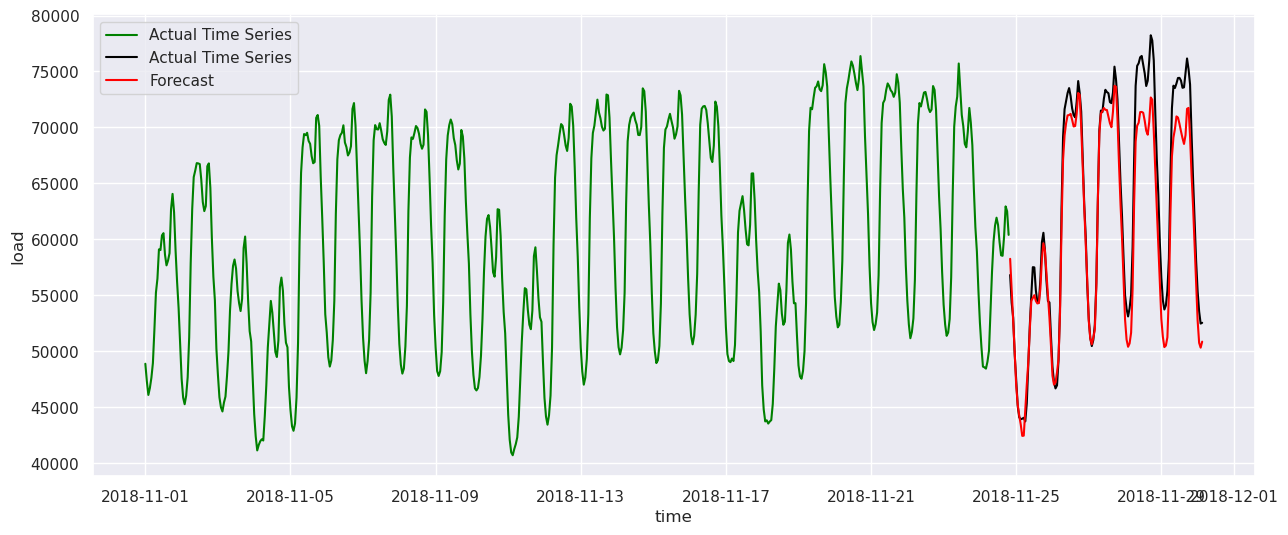

In [ ]:
# Let's Visualise the Data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
print(data.head())
warnings.filterwarnings('ignore') #Again to set the warnings to be ignored
# To set the style for seaborn
sns.set(style="darkgrid")
# Plot size
plt.figure(figsize=(15, 6))
# Plot forecasted value
sns.lineplot(x="ds", y='load', data=train_df, color='green', label='Actual Time Series')
sns.lineplot(x="ds", y='load', data=test_df, color='black', label='Actual Time Series')
# Plot actual timeseries data
sns.lineplot(x="ds", y='timesfm', data=timesfm_forecast, color='red', label='Forecast')
# Set plot title and labels
plt.ylabel('load')
plt.xlabel('time')
#plt.title('Electric Load: Actual vs Forecast')
# Show the legend
plt.legend()
plt.savefig('hourlyload forecast with Time FM.png')
# Display the plot
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Step 6: Evaluate Performance
mse_test = mean_squared_error(test_df['load'], timesfm_forecast['timesfm'])
mape_test = mean_absolute_percentage_error(test_df['load'], timesfm_forecast['timesfm'])

print("Testing Mean Squared Error (MSE):", mse_test)
print("Testing Mean Absolute Percentage Error (MAPE):", mape_test)

Testing Mean Squared Error (MSE): 7672175.365230441
Testing Mean Absolute Percentage Error (MAPE): 0.03326227576904363
